In [1]:
import numpy as np
import gymnasium as gym
import tensorflow as tf
import matplotlib.pyplot as plt

### Random Agent

In [2]:
env = gym.make("CartPole-v1", render_mode="human")

print(env.action_space)
print(env.observation_space)

for i in range(10):
    state, info = env.reset()
    done = False
    
    total_reward = 0

    while not done:
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)

        total_reward += reward
        done = terminated or truncated

    print(f"Episode {i}: Total Reward: {total_reward}")

env.close()

Discrete(2)
Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Episode 0: Total Reward: 19.0
Episode 1: Total Reward: 27.0
Episode 2: Total Reward: 22.0
Episode 3: Total Reward: 49.0
Episode 4: Total Reward: 24.0
Episode 5: Total Reward: 24.0
Episode 6: Total Reward: 15.0
Episode 7: Total Reward: 16.0
Episode 8: Total Reward: 12.0
Episode 9: Total Reward: 26.0


#### Semi-Gradient SARSA

In [3]:
env = gym.make("CartPole-v1")

Q_network = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(4,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(2, activation="linear")
])

# PARAMETERS
EPSILON = 1.0
EPSILON_DECAY = 0.995
GAMMA = 0.99
ALPHA = 0.001
NUM_EPISODES = 500

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


def greedy_policy(state, epsilon=0.0):
    if np.random.random() <= epsilon:
        return env.action_space.sample()
    else:
        q_values = Q_network(state)
        return np.argmax(q_values.numpy()[0])


episode_rewards = []

for episode in range(NUM_EPISODES):
    state, info = env.reset()
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    action = greedy_policy(state, EPSILON)
    done = False

    total_reward = 0
    episode_len = 0

    while not done:
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)
        next_action = greedy_policy(next_state, EPSILON)

        target = reward

        if not terminated or truncated:
            next_q_values = Q_network(next_state)
            target += GAMMA * next_q_values[0][next_action]

        # with tf.GradientTape() as tape:
        #     q_values = Q_network(state)

        # grads = tape.gradient(q_values, Q_network.trainable_weights)
        # delta = target - q_values[0][action]

        # for j in range(len(grads)):
        #     Q_network.trainable_weights[j].assign_add(ALPHA * delta * grads[j])

        with tf.GradientTape() as tape:
            q_values = Q_network(state)
            q_value = q_values[0][action]

            target = tf.expand_dims(target, axis=0)
            q_value = tf.expand_dims(q_value, axis=0)

            loss = tf.keras.losses.MSE(target, q_value)

        grads = tape.gradient(loss, Q_network.trainable_variables)
        optimizer.apply_gradients(zip(grads, Q_network.trainable_variables))

        state = next_state
        action = next_action

        total_reward += reward
        episode_len += 1

        done = terminated or truncated

    episode_rewards.append(total_reward)
    print(f"Episode {episode}: Total Reward: {total_reward}, Episode Length: {episode_len}, Epsilon: {EPSILON}")
    EPSILON = max(0.01, EPSILON * EPSILON_DECAY)

print("Training Completed!")
Q_network.save("models/SARSA_cartpole")
env.close()

Episode 0: Total Reward: 35.0, Episode Length: 35, Epsilon: 0.995
Episode 1: Total Reward: 24.0, Episode Length: 24, Epsilon: 0.990025
Episode 2: Total Reward: 36.0, Episode Length: 36, Epsilon: 0.985074875
Episode 3: Total Reward: 13.0, Episode Length: 13, Epsilon: 0.9801495006250001
Episode 4: Total Reward: 33.0, Episode Length: 33, Epsilon: 0.9752487531218751
Episode 5: Total Reward: 11.0, Episode Length: 11, Epsilon: 0.9703725093562657
Episode 6: Total Reward: 22.0, Episode Length: 22, Epsilon: 0.9655206468094844
Episode 7: Total Reward: 32.0, Episode Length: 32, Epsilon: 0.960693043575437
Episode 8: Total Reward: 17.0, Episode Length: 17, Epsilon: 0.9558895783575597
Episode 9: Total Reward: 22.0, Episode Length: 22, Epsilon: 0.9511101304657719
Episode 10: Total Reward: 11.0, Episode Length: 11, Epsilon: 0.946354579813443
Episode 11: Total Reward: 15.0, Episode Length: 15, Epsilon: 0.9416228069143757
Episode 12: Total Reward: 16.0, Episode Length: 16, Epsilon: 0.9369146928798039
Ep

INFO:tensorflow:Assets written to: models/SARSA_cartpole\assets


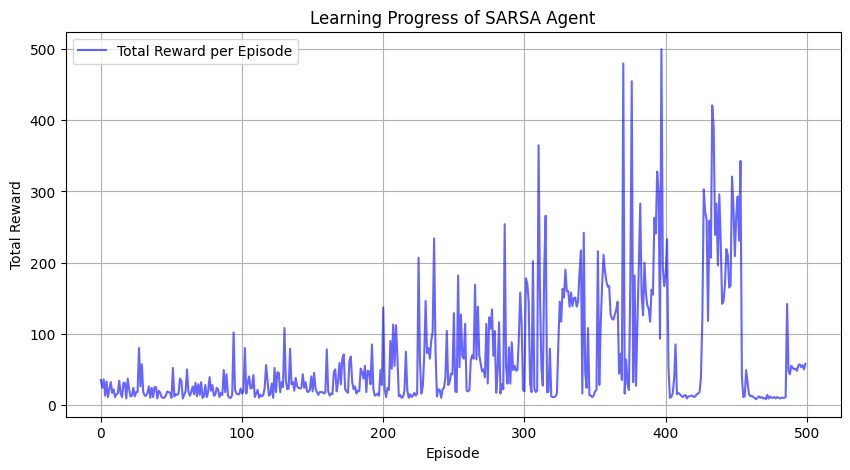

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label="Total Reward per Episode", color='blue', alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Progress of SARSA Agent")
plt.legend()
plt.grid()
plt.show()

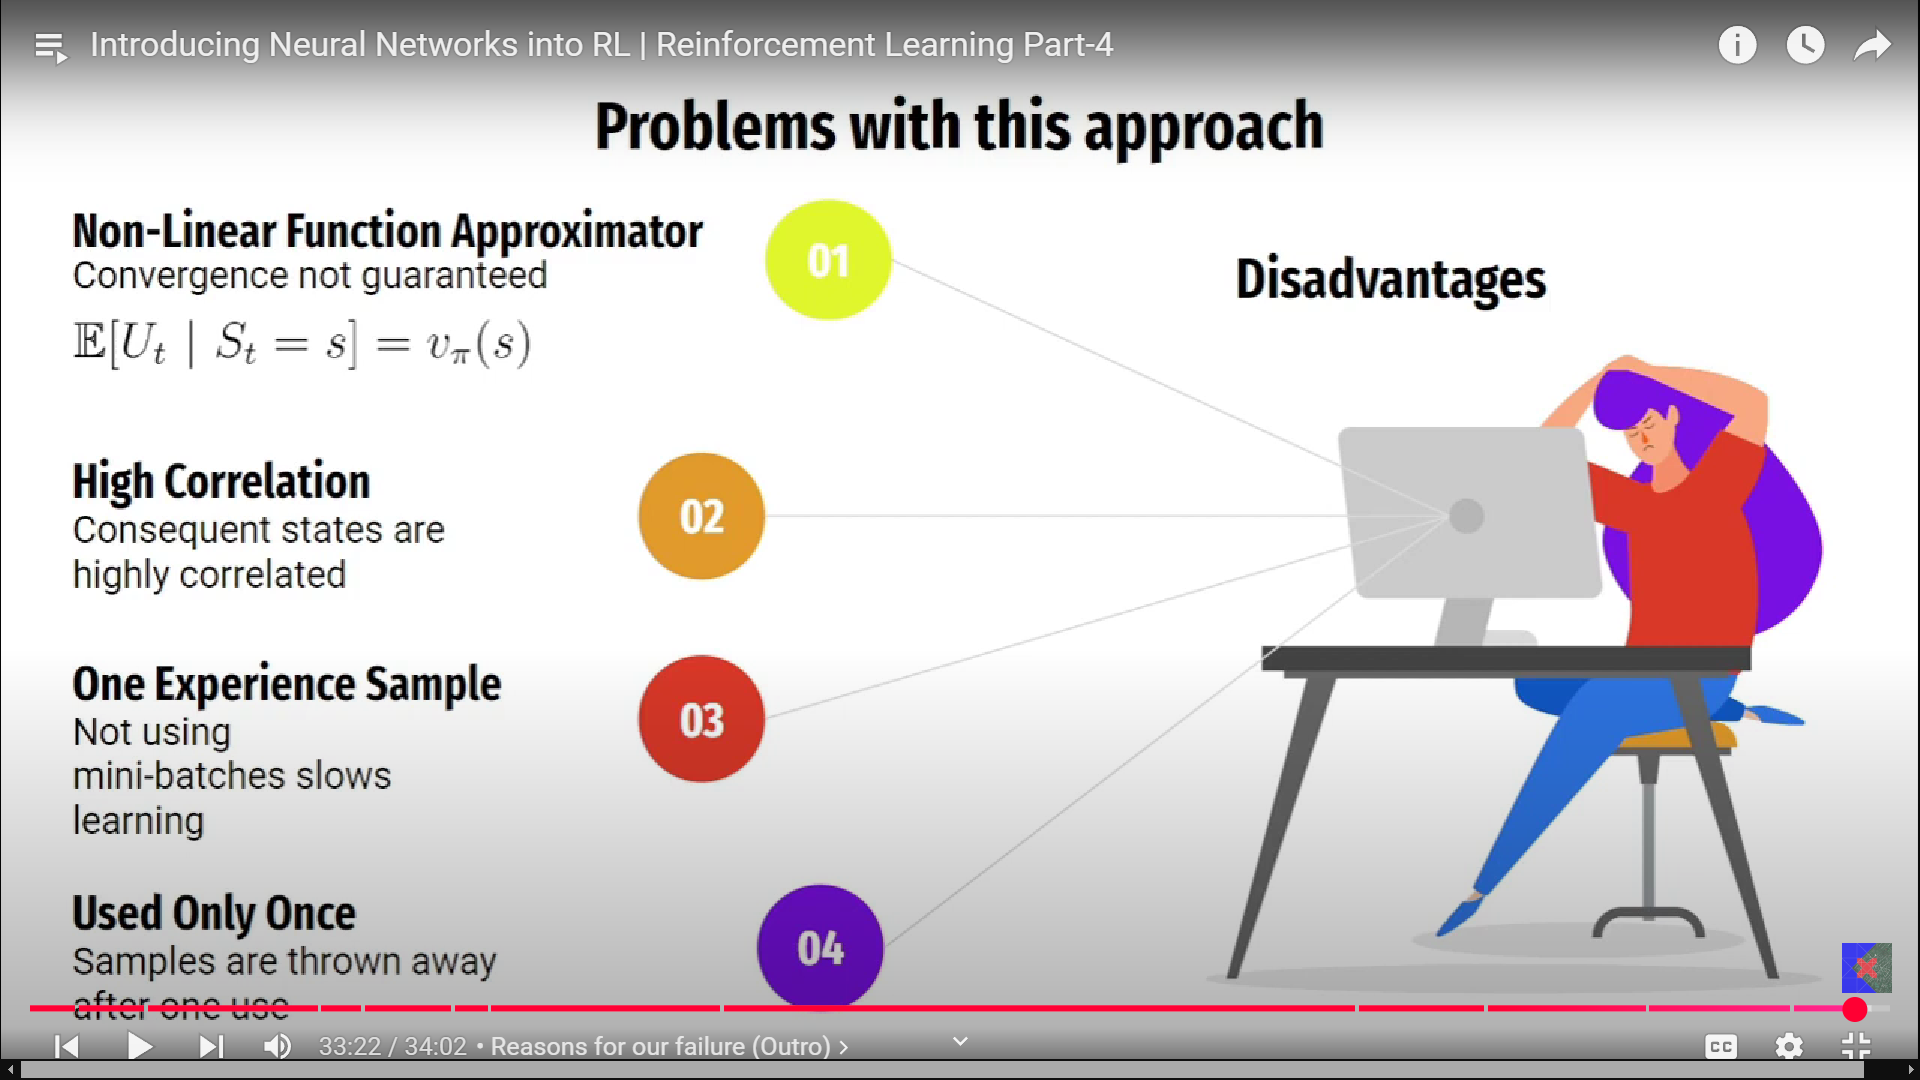

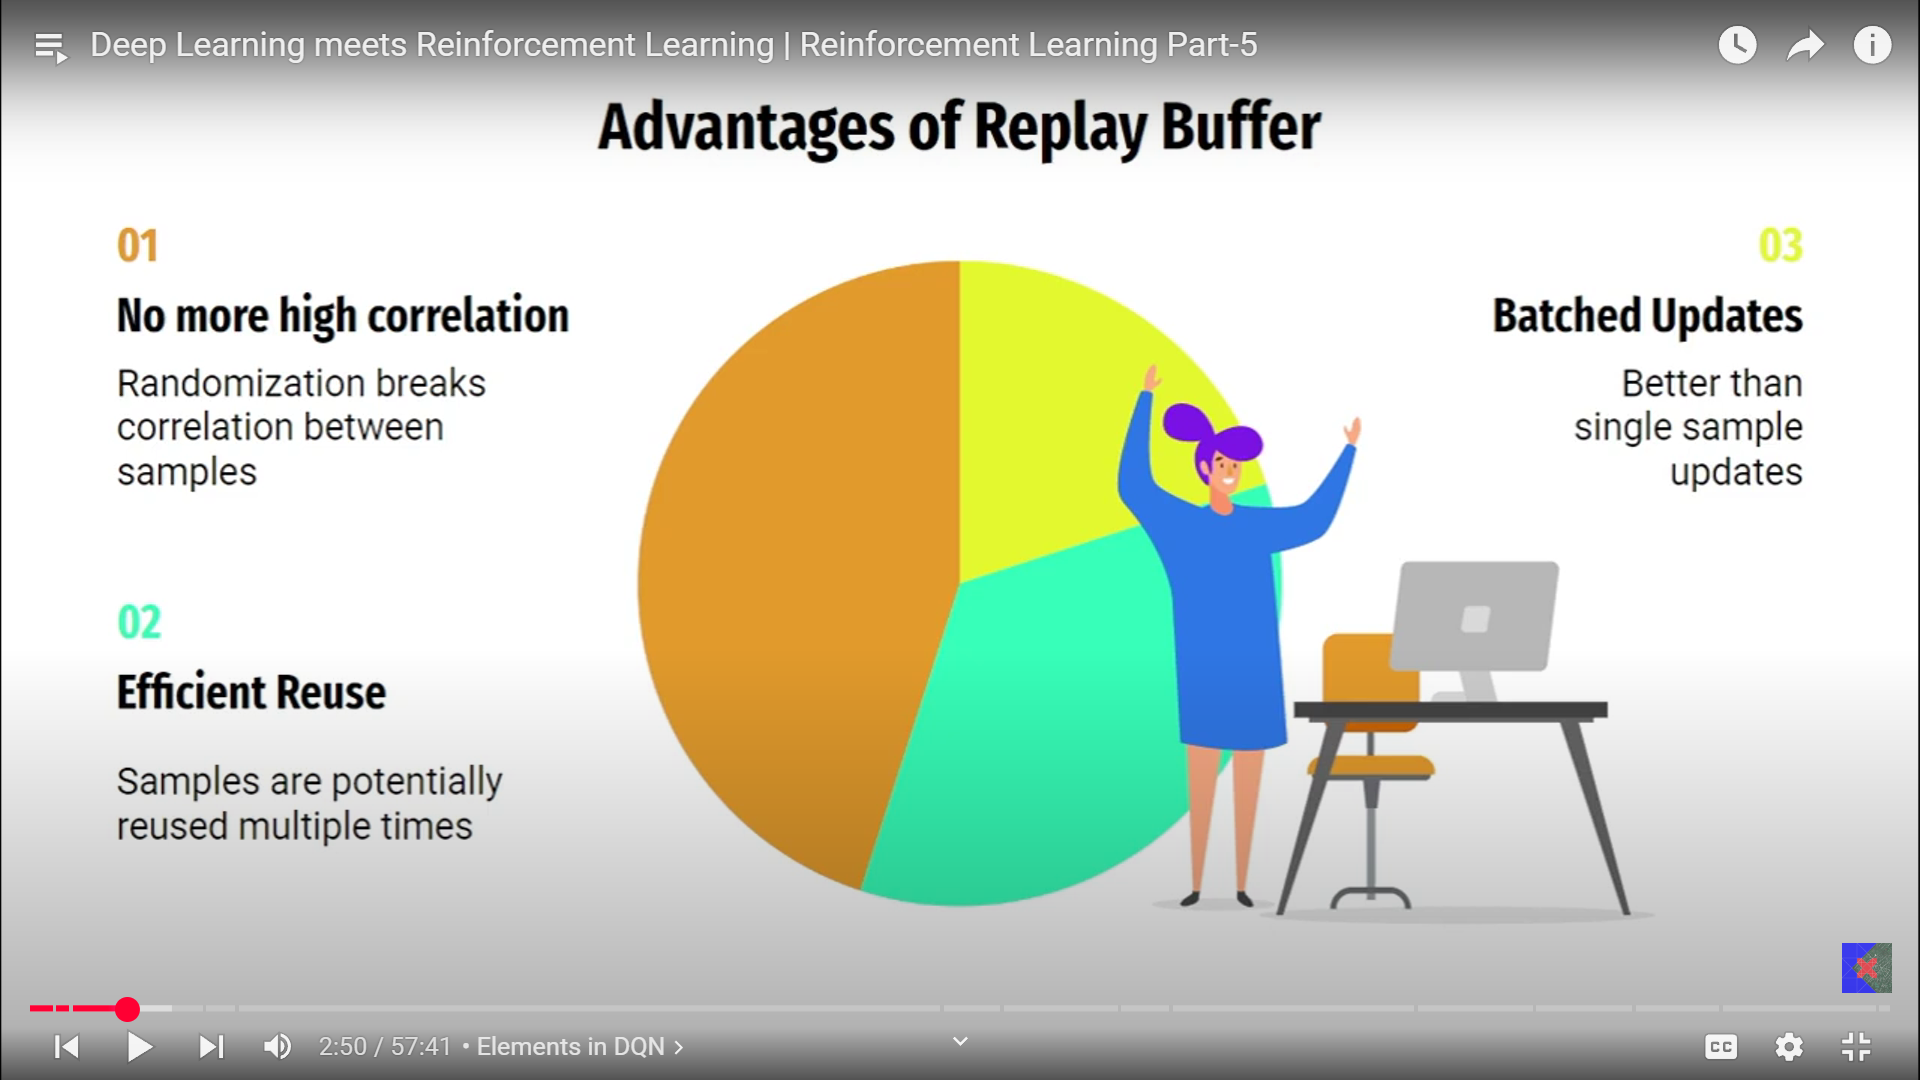